In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import RootMeanSquaredError
from kerastuner.tuners import RandomSearch
from kerastuner import Objective
import tensorflow as tf
from math import sqrt

<ipython-input-2-2bc06e733f44>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

To forecast the sales of the two best-selling products, I will split the dataset into two, one for item A and one for item B.

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv')

# Keep only one observation per day
data = data.drop_duplicates(subset=['date', 'item_name'], keep='first')

# Filter the data for item_name 'A'
data_a = data[data['item_name'] == 'A']

# Filter the data for item_name 'B'
data_b = data[data['item_name'] == 'B']

# Save the filtered data to new CSV files
data_a.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_A.csv', index=False)
data_b.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_B.csv', index=False)

Features processing A and B

In [ ]:
# Model LSTM A

data_a = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_A.csv', index_col='date')

# Convert the index to datetime format
data_a.index = pd.to_datetime(data_a.index)

# Check the number of unique values in 'item_nbr', 'item_name', and 'class'
print("Unique values in 'item_nbr':", data_a['item_nbr'].nunique())
print("Unique values in 'item_name':", data_a['item_name'].nunique())
print("Unique values in 'class':", data_a['class'].nunique())

# If these columns have only one unique value, drop them from the dataset
if data_a['item_nbr'].nunique() == 1:
    data_a.drop('item_nbr', axis=1, inplace=True)
if data_a['item_name'].nunique() == 1:
    data_a.drop('item_name', axis=1, inplace=True)
if data_a['class'].nunique() == 1:
    data_a.drop('class', axis=1, inplace=True)

# Also, drop the 'id' column as it is just an identifier
data_a.drop('id', axis=1, inplace=True)

#data_a.drop(['month', 'day_of_month', 'week_of_month', 'day_of_week', 'season'], axis=1, inplace=True)
#data_a.drop(['month_sin', 'day_of_month_sin', 'week_of_month_sin', 'day_of_week_sin', 'season_sin', 'month_cos', 'day_of_month_cos', 'week_of_month_cos', 'day_of_week_cos', 'season_cos'], axis=1, inplace=True)
print(data_a.head())

Unique values in 'item_nbr': 1
Unique values in 'item_name': 1
Unique values in 'class': 1
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-01-02         117        False           False              True   
2015-01-03         110        False           False             False   
2015-01-04         180        False           False             False   
2015-01-05         106        False           False             False   
2015-01-06          87        False           False             False   

            holiday_local  month  day_of_month  week_of_month  day_of_week  \
date                                                                         
2015-01-02          False      1             2              1            5   
2015-01-03          False      1             3              1            6   
2015-01-04          False      1             4              1            7   
2015-01

In [ ]:
# Model LSTM B

data_b = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_B.csv', index_col='date')

# Convert the index to datetime format
data_b.index = pd.to_datetime(data_b.index)

# Check the number of unique values in 'item_nbr', 'item_name', and 'class'
print("Unique values in 'item_nbr':", data_b['item_nbr'].nunique())
print("Unique values in 'item_name':", data_b['item_name'].nunique())
print("Unique values in 'class':", data_b['class'].nunique())

# If these columns have only one unique value, drop them from the dataset
if data_b['item_nbr'].nunique() == 1:
    data_b.drop('item_nbr', axis=1, inplace=True)
if data_b['item_name'].nunique() == 1:
    data_b.drop('item_name', axis=1, inplace=True)
if data_b['class'].nunique() == 1:
    data_b.drop('class', axis=1, inplace=True)

# Also, drop the 'id' column as it is just an identifier
data_b.drop('id', axis=1, inplace=True)

#data_b.drop(['month', 'day_of_month', 'week_of_month', 'day_of_week', 'season'], axis=1, inplace=True)
#data_b.drop(['month_sin', 'day_of_month_sin', 'week_of_month_sin', 'day_of_week_sin', 'season_sin', 'month_cos', 'day_of_month_cos', 'week_of_month_cos', 'day_of_week_cos', 'season_cos'], axis=1, inplace=True)
print(data_b.head())

Unique values in 'item_nbr': 1
Unique values in 'item_name': 1
Unique values in 'class': 1
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-01-02          90        False           False              True   
2015-01-03          97        False           False             False   
2015-01-04          94        False           False             False   
2015-01-05          81        False           False             False   
2015-01-06         119        False           False             False   

            holiday_local  month  day_of_month  week_of_month  day_of_week  \
date                                                                         
2015-01-02          False      1             2              1            5   
2015-01-03          False      1             3              1            6   
2015-01-04          False      1             4              1            7   
2015-01

Dataset A and B: Training set of 6 month history before the start of the evaluation period (evaluation period = May 2016)

In [ ]:
# Two years of data
dataset_LSTM_A = data_a['2015-01-01':'2017-01-01']
dataset_LSTM_B = data_b['2015-01-01':'2017-01-01']

# Calculate the start date six months before the test start date
historical_start_date = pd.to_datetime('2016-04-30') - pd.DateOffset(months=6)

# Calculate the end date as the test start date
historical_end_date = pd.to_datetime('2016-04-30')

# Filter the historical data for six months period prior to the test start date
train_A = data_a[(data_a.index >= historical_start_date) & (data_a.index < historical_end_date)]
train_B = data_b[(data_b.index >= historical_start_date) & (data_b.index < historical_end_date)]

# Display the first row of the train data
print("\nFirst row of train data:")
print(train_A)
print("Shape:", train_A.shape)

print("\nFirst row of train data:")
print(train_B)
print("Shape:", train_B.shape)


First row of train data:
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-10-30          39        False           False             False   
2015-10-31          76        False           False             False   
2015-11-01          55        False           False             False   
2015-11-02          70        False           False              True   
2015-11-03         106        False           False              True   
...                ...          ...             ...               ...   
2016-04-25          55        False            True             False   
2016-04-26          40        False            True             False   
2016-04-27          52        False            True             False   
2016-04-28          35        False            True             False   
2016-04-29          66        False            True             False   

            holiday_loca

# LSTM Model

## Data Prepreprocessing

## Best LSTM models

Preprocess the data to the LSTM requirements

Feature scaling: scaling the features is needed for the LSTM model to facilitate faster convergence and ensure fair treatment of features to enhance generalization of the model

https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/


In [ ]:
# Model LSTM A

train_start_date_LSTM_A = pd.to_datetime('2016-04-30') - pd.DateOffset(months=6)
train_end_date_LSTM_A = pd.to_datetime('2016-04-30')
train_A_LSTM_A = data_a[train_start_date_LSTM_A:train_end_date_LSTM_A]

test_A_start_date_LSTM_A = '2016-05-01'
test_A_end_date_LSTM_A = '2016-05-31'
test_A_LSTM_A = data_a[test_A_start_date_LSTM_A:test_A_end_date_LSTM_A]

# Scale both dataset
scaler_LSTM_A = MinMaxScaler()
train_scaled_LSTM_A = scaler_LSTM_A.fit_transform(train_A_LSTM_A)
test_scaled_LSTM_A = scaler_LSTM_A.transform(test_A_LSTM_A)


In [ ]:
# Model LSTM B

train_start_date_LSTM_B = pd.to_datetime('2016-04-30') - pd.DateOffset(months=6)
train_end_date_LSTM_B = pd.to_datetime('2016-04-30')
train_B_LSTM_B = data_b[train_start_date_LSTM_B:train_end_date_LSTM_B]

test_B_start_date_LSTM_B = '2016-05-01'
test_B_end_date_LSTM_B = '2016-05-31'
test_B_LSTM_B = data_b[test_B_start_date_LSTM_B:test_B_end_date_LSTM_B]

# Scale both dataset
scaler_LSTM_B = MinMaxScaler()
train_scaled_LSTM_B = scaler_LSTM_B.fit_transform(train_B_LSTM_B)
test_scaled_LSTM_B = scaler_LSTM_B.transform(test_B_LSTM_B)

Visualization of the feature scaling

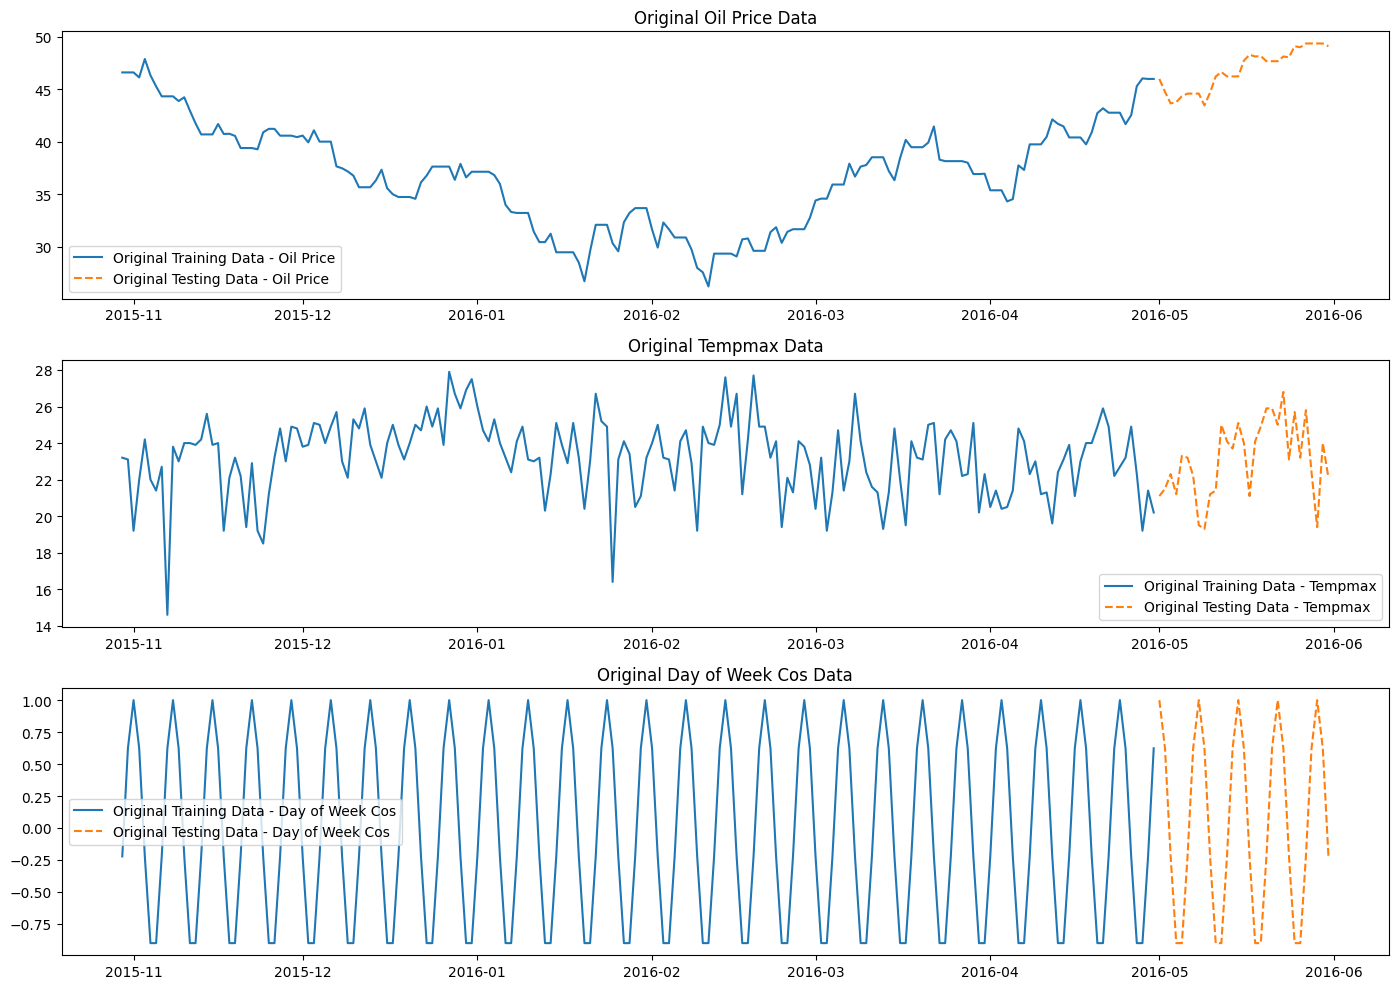

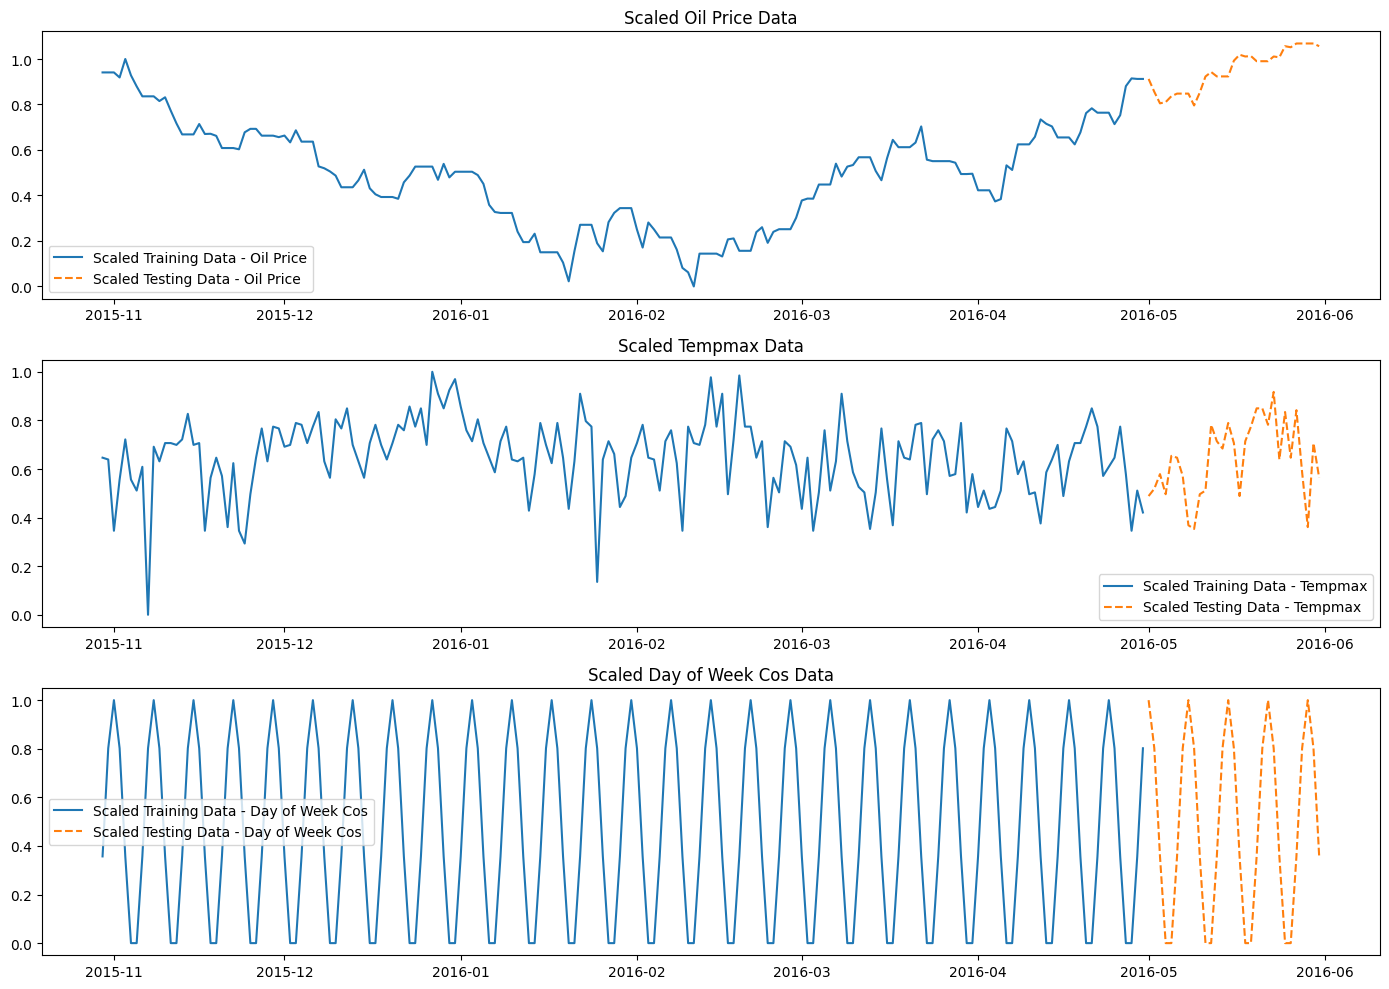

In [ ]:
# Convert scaled data back to DataFrame for easy plotting
train_scaled_LSTM_A_df = pd.DataFrame(train_scaled_LSTM_A, index=train_A_LSTM_A.index, columns=train_A_LSTM_A.columns)
test_scaled_LSTM_A_df = pd.DataFrame(test_scaled_LSTM_A, index=test_A_LSTM_A.index, columns=test_A_LSTM_A.columns)

# Plot the original and scaled data
plt.figure(figsize=(14, 10))

# Plot original training data
plt.subplot(3, 1, 1)
plt.plot(train_A_LSTM_A['oil_price'], label='Original Training Data - Oil Price')
plt.plot(test_A_LSTM_A['oil_price'], label='Original Testing Data - Oil Price', linestyle='--')
plt.title('Original Oil Price Data')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_A_LSTM_A['tempmax'], label='Original Training Data - Tempmax')
plt.plot(test_A_LSTM_A['tempmax'], label='Original Testing Data - Tempmax', linestyle='--')
plt.title('Original Tempmax Data')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_A_LSTM_A['day_of_week_cos'], label='Original Training Data - Day of Week Cos')
plt.plot(test_A_LSTM_A['day_of_week_cos'], label='Original Testing Data - Day of Week Cos', linestyle='--')
plt.title('Original Day of Week Cos Data')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 10))

# Plot scaled training data
plt.subplot(3, 1, 1)
plt.plot(train_scaled_LSTM_A_df['oil_price'], label='Scaled Training Data - Oil Price')
plt.plot(test_scaled_LSTM_A_df['oil_price'], label='Scaled Testing Data - Oil Price', linestyle='--')
plt.title('Scaled Oil Price Data')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_scaled_LSTM_A_df['tempmax'], label='Scaled Training Data - Tempmax')
plt.plot(test_scaled_LSTM_A_df['tempmax'], label='Scaled Testing Data - Tempmax', linestyle='--')
plt.title('Scaled Tempmax Data')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_scaled_LSTM_A_df['day_of_week_cos'], label='Scaled Training Data - Day of Week Cos')
plt.plot(test_scaled_LSTM_A_df['day_of_week_cos'], label='Scaled Testing Data - Day of Week Cos', linestyle='--')
plt.title('Scaled Day of Week Cos Data')
plt.legend()

plt.tight_layout()
plt.show()

Sequences creation: transform the data into sequences that the LSTM model can process. The sequence lenght determines how many previous days' data the model should look at to predict the next day's sales. In this case, we will look at the 30 last days to predict the next day. The data is in a new 3D tensor composed of batch size (number of sequences processes simultaneously during training), timesteps ( length of each sequence), features (number of features or variables present at each time step within the sequence)

https://medium.com/@nutanbhogendrasharma/simple-sequence-prediction-with-lstm-69ff0f4d57cd

These functions also separate the target value (unit_sales) and the variables

In [ ]:
# Model LSTM A

def create_sequences_LSTM_A(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length, 1:]) # all features except the first (unit_sales)
        labels.append(data[i+sequence_length, 0])       # only the unit_sales value, which is our target
    return np.array(sequences), np.array(labels)

def create_test_sequences_LSTM_A(train_data, test_data, sequence_length):
    full_data = np.vstack((train_data, test_data))
    sequences = []
    start_index = len(train_data) - sequence_length
    for i in range(start_index, len(full_data) - sequence_length):
        sequences.append(full_data[i:i+sequence_length, 1:])
    return np.array(sequences)

sequence_length_train_LSTM_A = 7
sequence_length_test_LSTM_A = 7

X_train_LSTM_A, y_train_LSTM_A = create_sequences_LSTM_A(train_scaled_LSTM_A, sequence_length_train_LSTM_A)
X_test_LSTM_A = create_test_sequences_LSTM_A(train_scaled_LSTM_A, test_scaled_LSTM_A, sequence_length_test_LSTM_A)

print(X_train_LSTM_A.shape)
print(X_test_LSTM_A.shape)

(177, 7, 25)
(31, 7, 25)


In [ ]:
# Model LSTM B

def create_sequences_LSTM_B(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length, 1:]) # all features except the first (unit_sales)
        labels.append(data[i+sequence_length, 0])       # only the unit_sales value, which is our target
    return np.array(sequences), np.array(labels)

def create_test_sequences_LSTM_B(train_data, test_data, sequence_length):
    full_data = np.vstack((train_data, test_data))
    sequences = []
    start_index = len(train_data) - sequence_length
    for i in range(start_index, len(full_data) - sequence_length):
        sequences.append(full_data[i:i+sequence_length, 1:])
    return np.array(sequences)

sequence_length_train_LSTM_B = 7
sequence_length_test_LSTM_B = 7

X_train_LSTM_B, y_train_LSTM_B = create_sequences_LSTM_B(train_scaled_LSTM_B, sequence_length_train_LSTM_B)
X_test_LSTM_B = create_test_sequences_LSTM_B(train_scaled_LSTM_B, test_scaled_LSTM_B, sequence_length_test_LSTM_B)

print(X_train_LSTM_B.shape)
print(X_test_LSTM_B.shape)

(177, 7, 25)
(31, 7, 25)


Visualization of the sequences

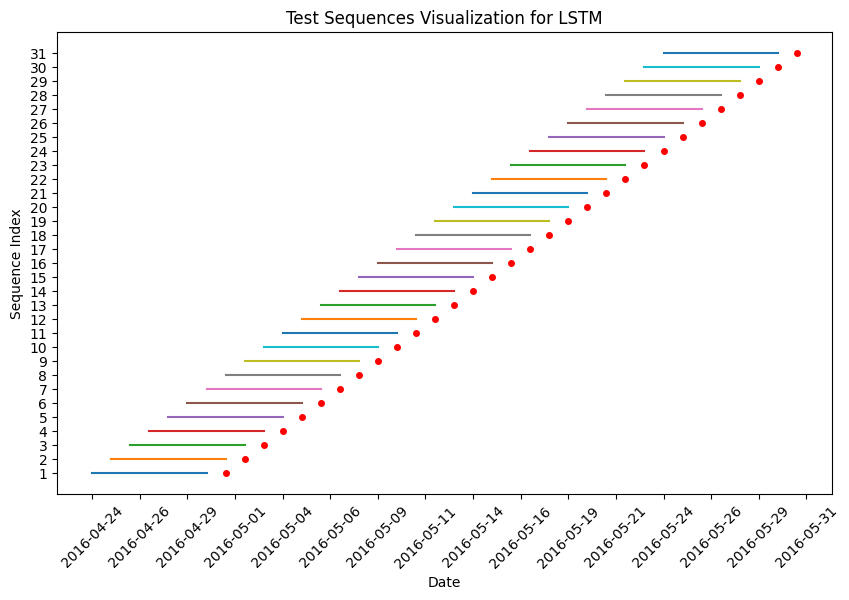

In [ ]:
dates = pd.date_range(start='2016-01-01', periods=len(train_scaled_LSTM_A) + len(test_scaled_LSTM_A), freq='D')

# Visualize the test sequences
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the test sequences starting from 7 days before May 1, 2016
start_test_date = '2016-05-01'
start_test_index = dates.get_loc(start_test_date) - sequence_length_test_LSTM_A

for i in range(X_test_LSTM_A.shape[0]):
    sequence_dates = dates[start_test_index + i : start_test_index + i + sequence_length_test_LSTM_A]
    forecasted_day = sequence_dates[-1] + pd.Timedelta(days=1)

    # Plot the sequence
    ax.plot(sequence_dates, np.ones(sequence_length_test_LSTM_A) * (i + 1), label=f'Sequence {i + 1}')

    # Plot the forecasted day
    ax.plot(forecasted_day, i + 1, 'ro', markersize=4)

ax.set_xlabel('Date')
ax.set_ylabel('Sequence Index')
ax.set_title('Test Sequences Visualization for LSTM')
ax.set_yticks(range(1, X_test_LSTM_A.shape[0] + 1))

# Rotate date labels and adjust number of displayed labels
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=20))

plt.show()

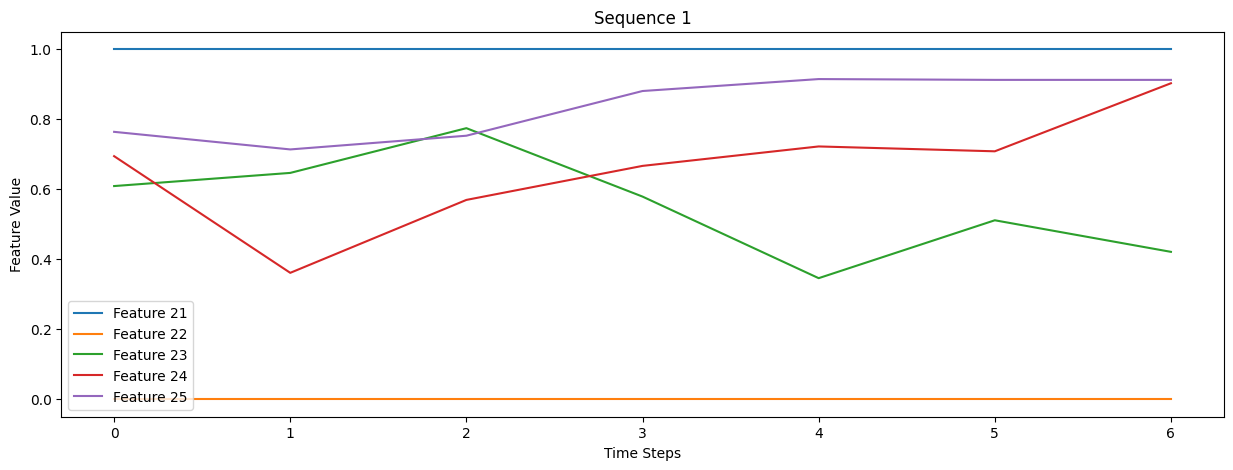

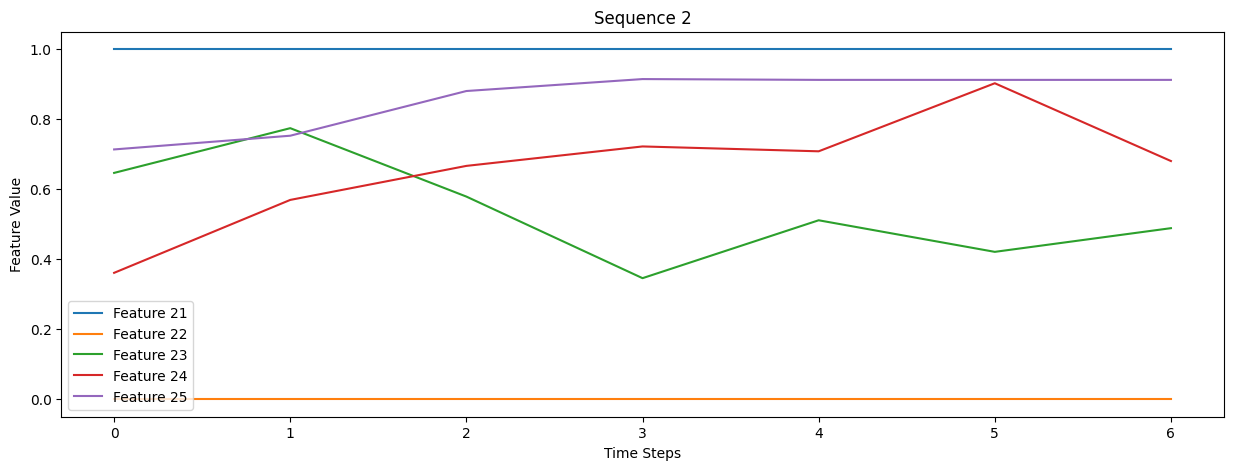

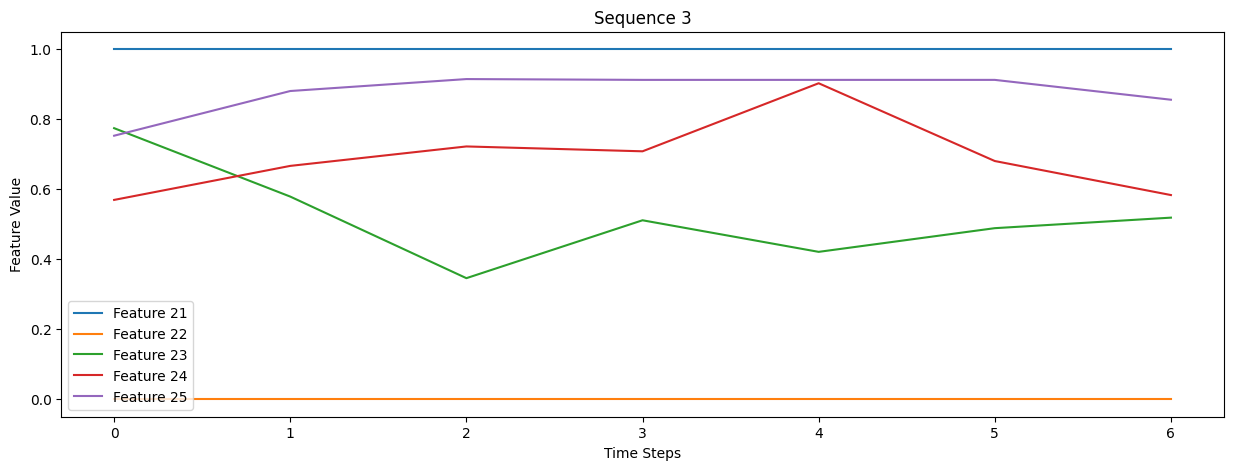

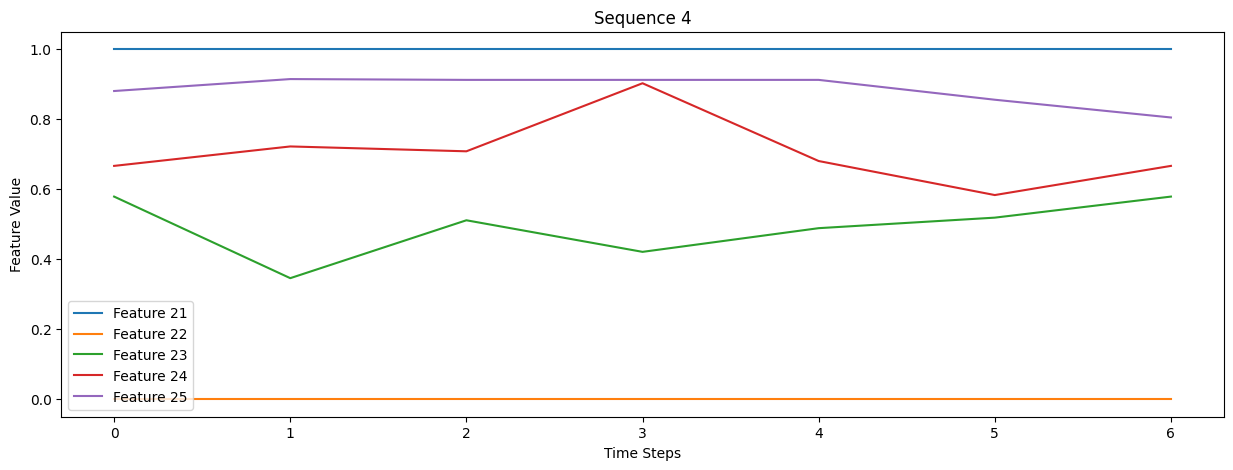

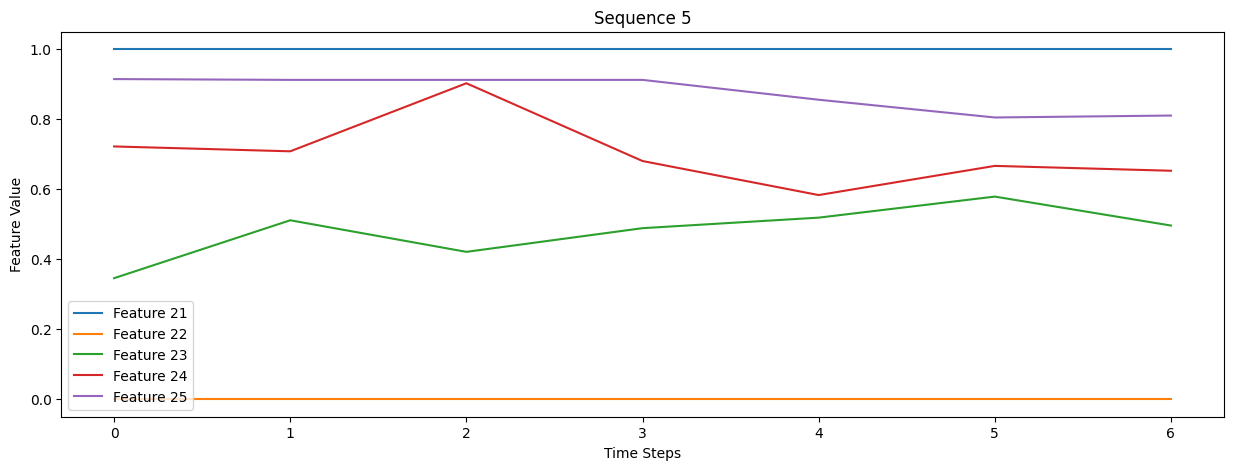

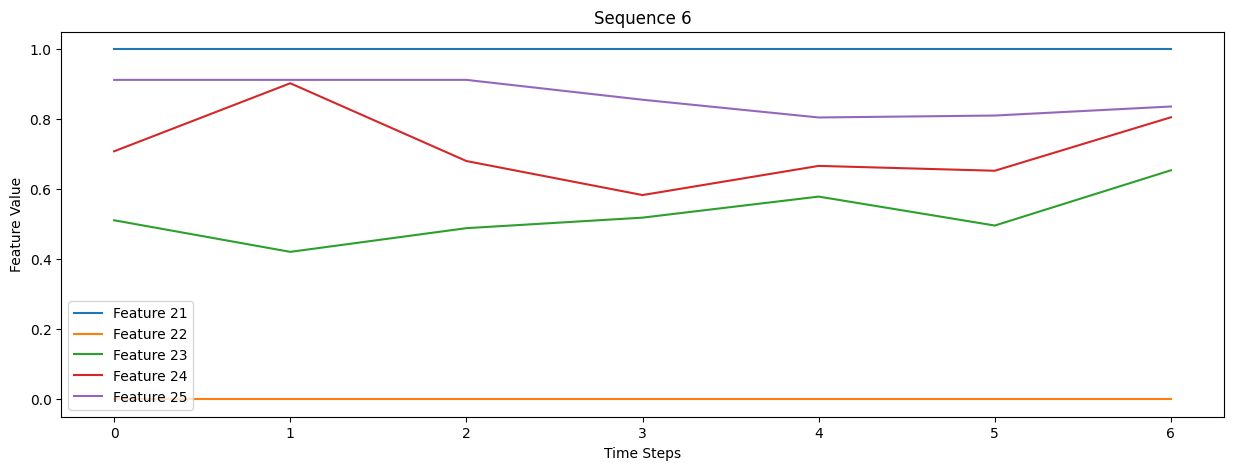

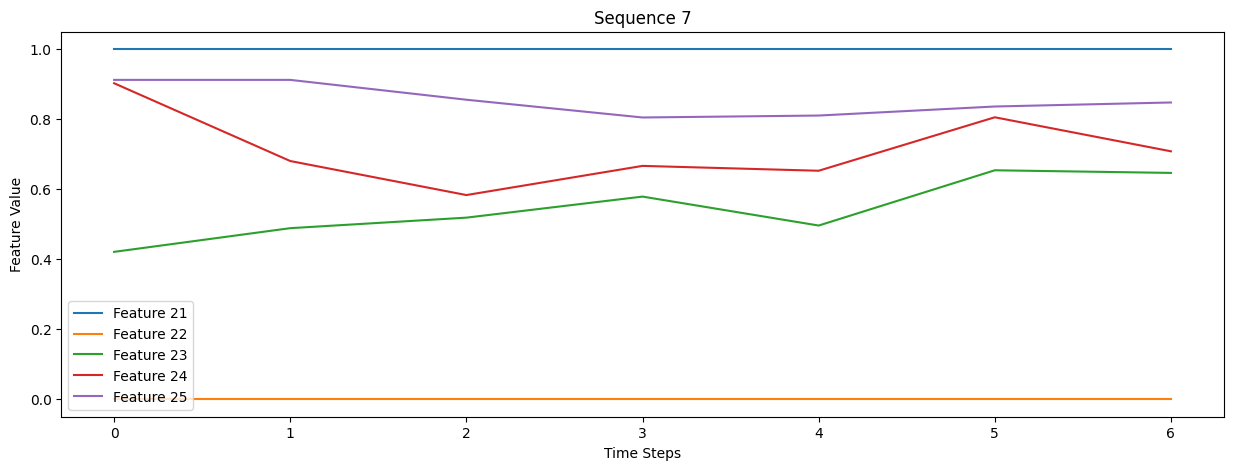

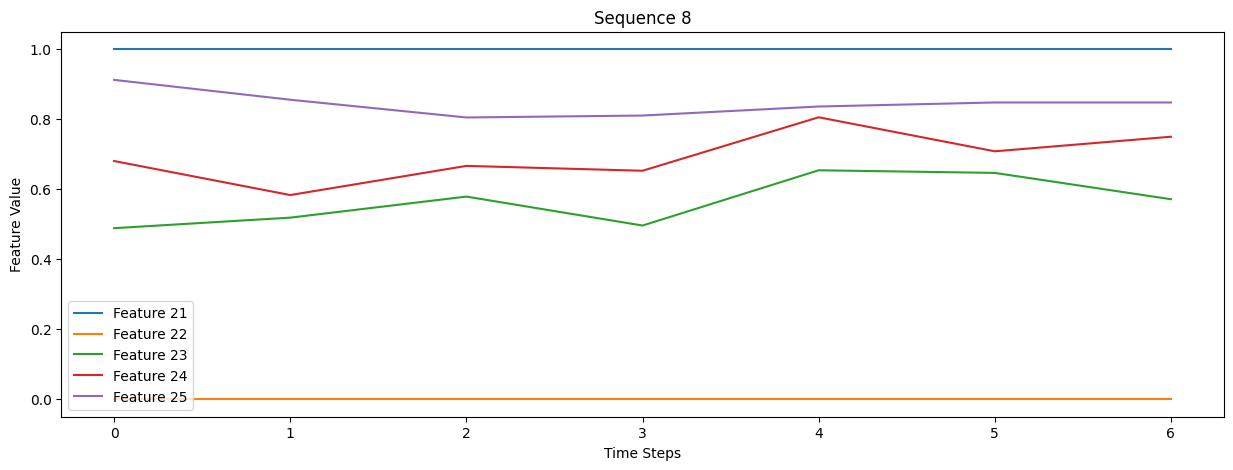

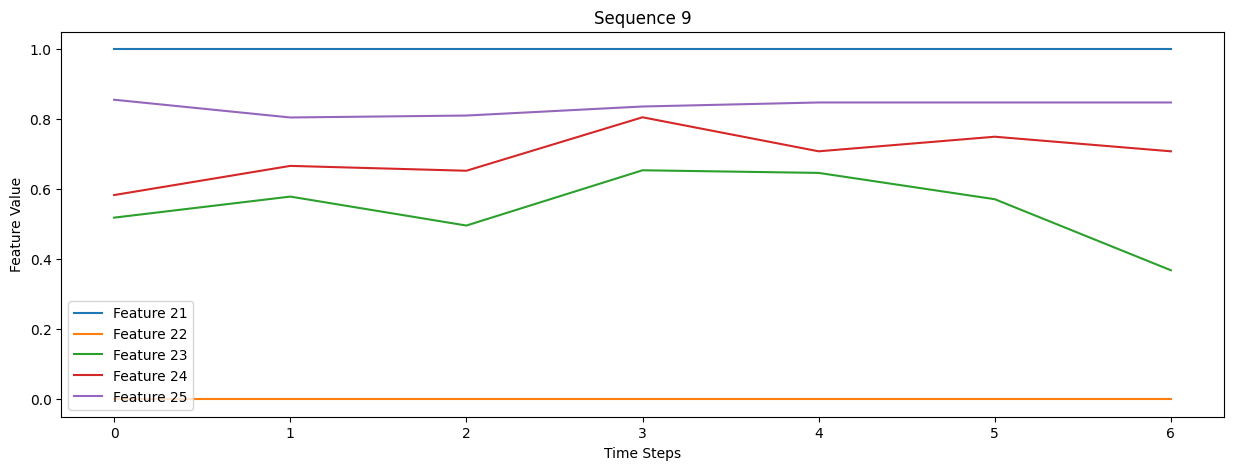

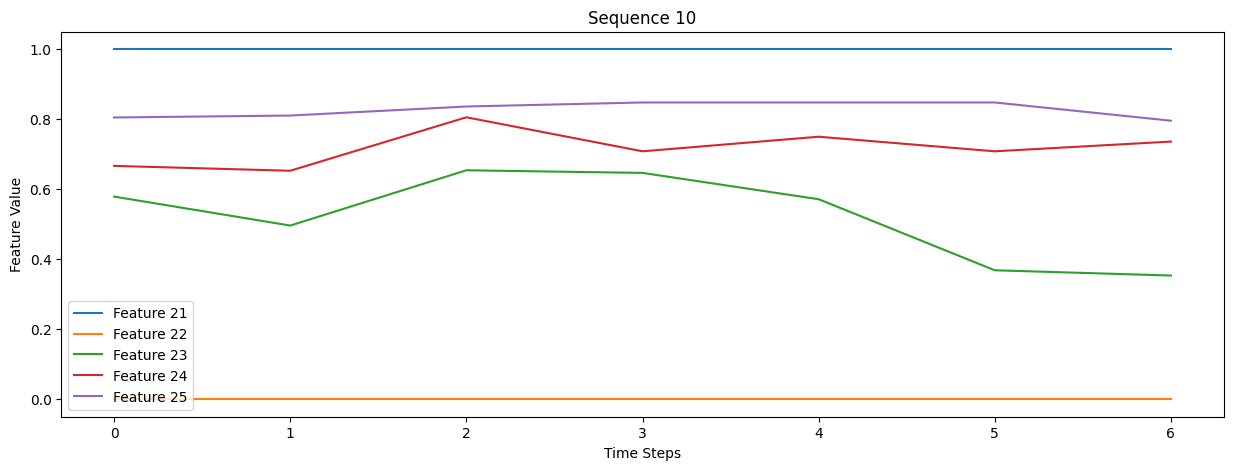

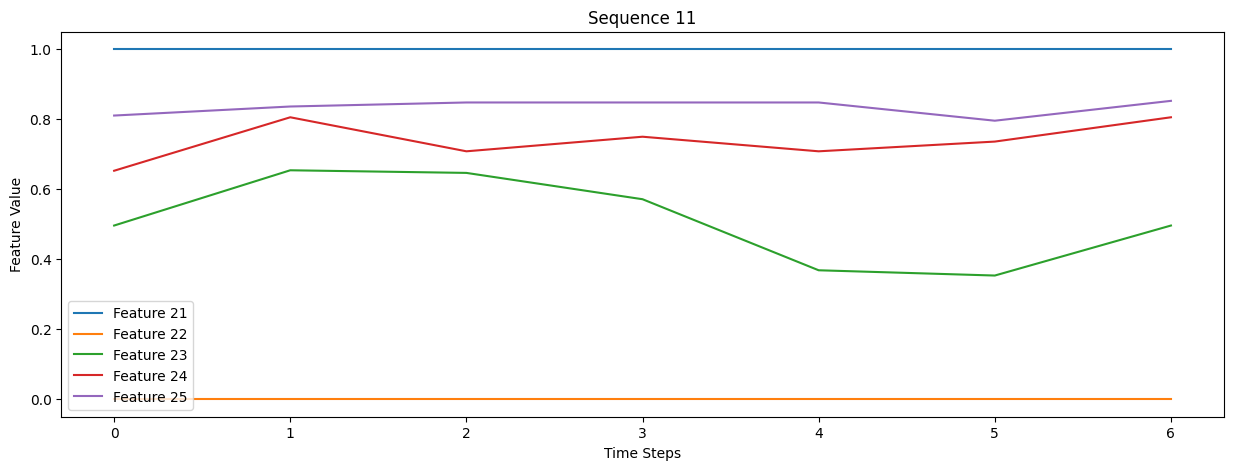

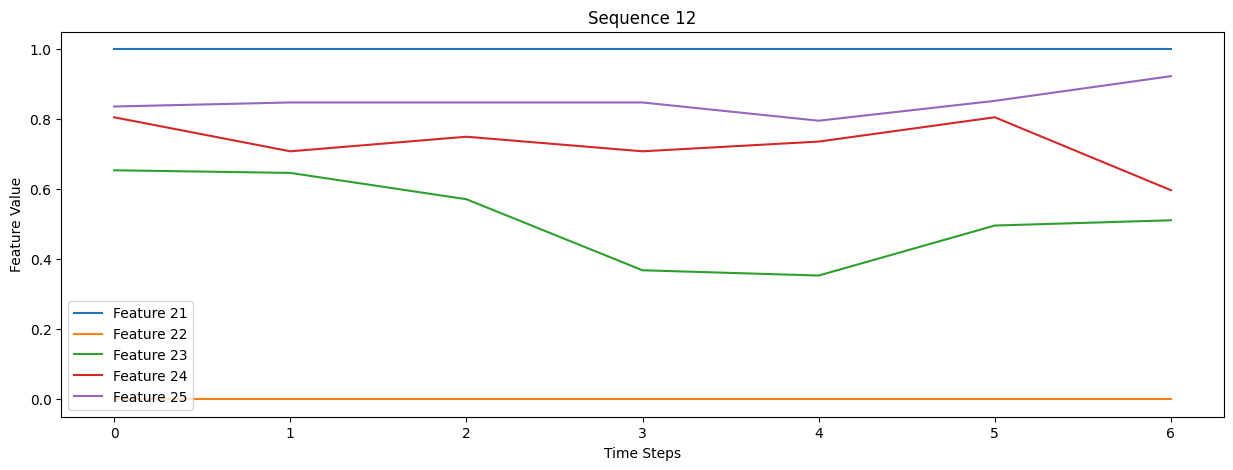

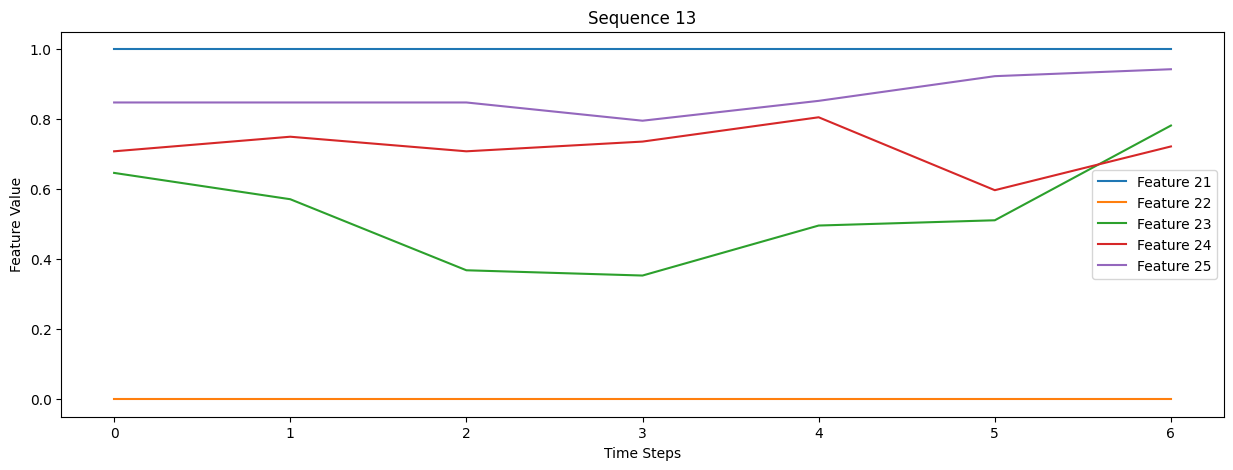

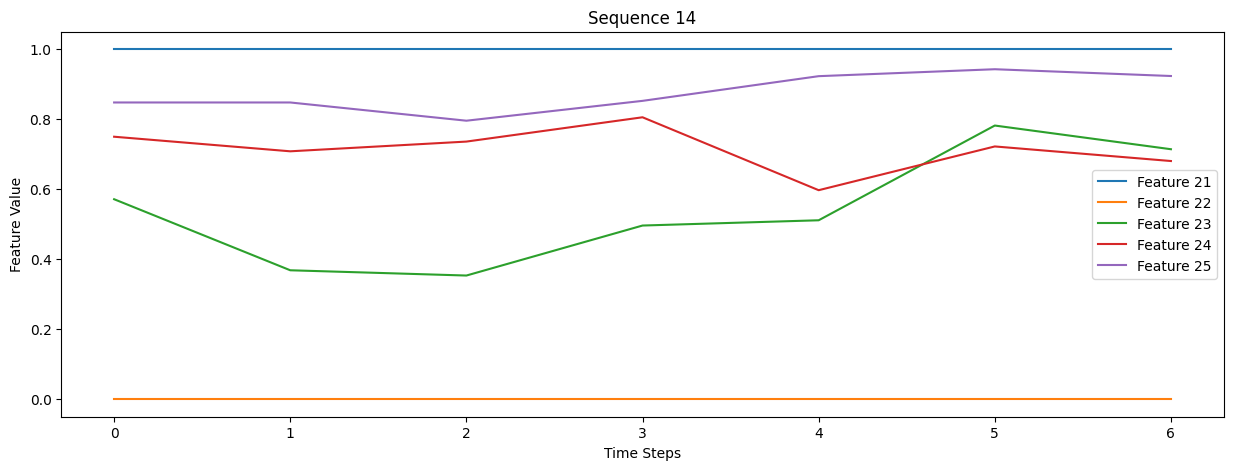

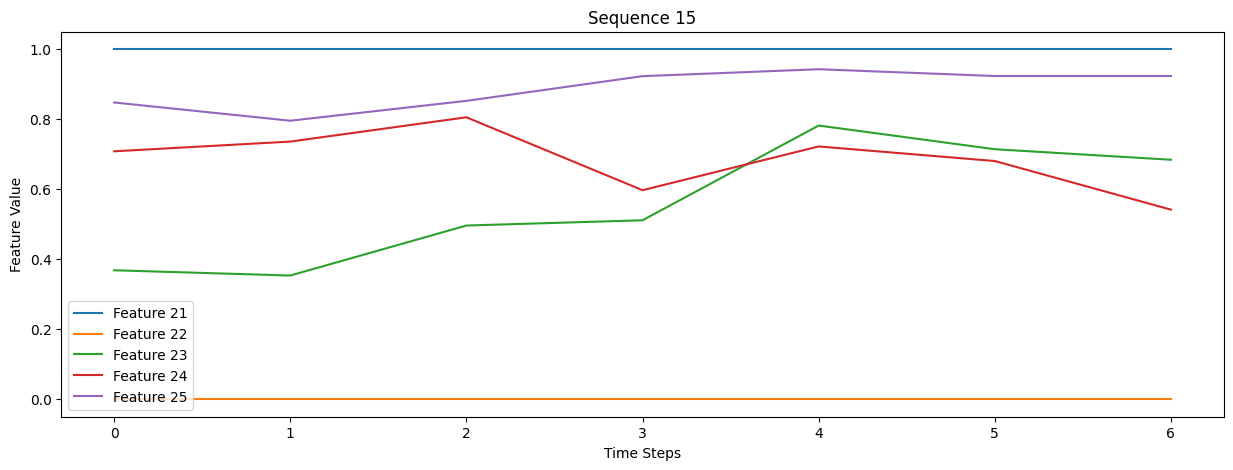

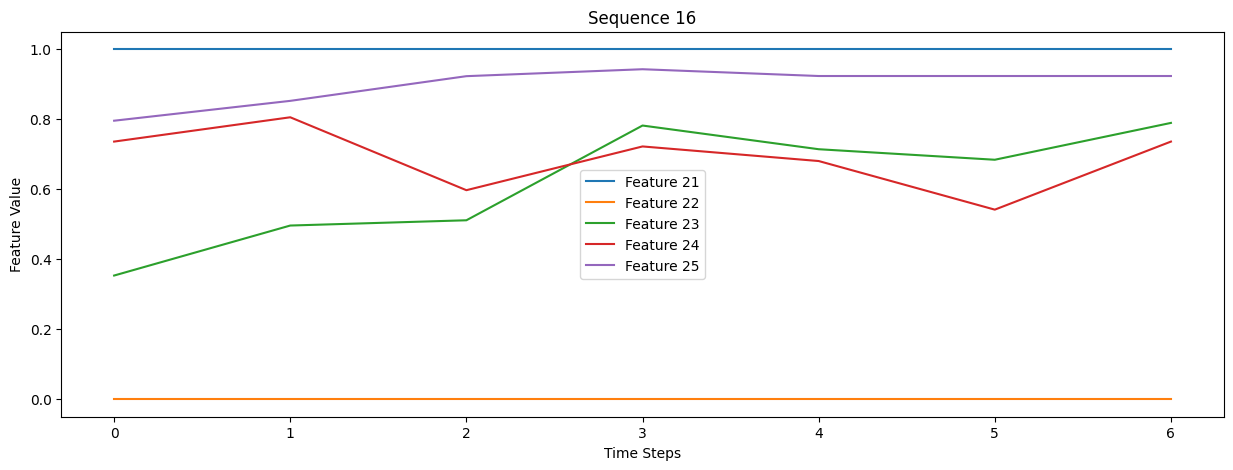

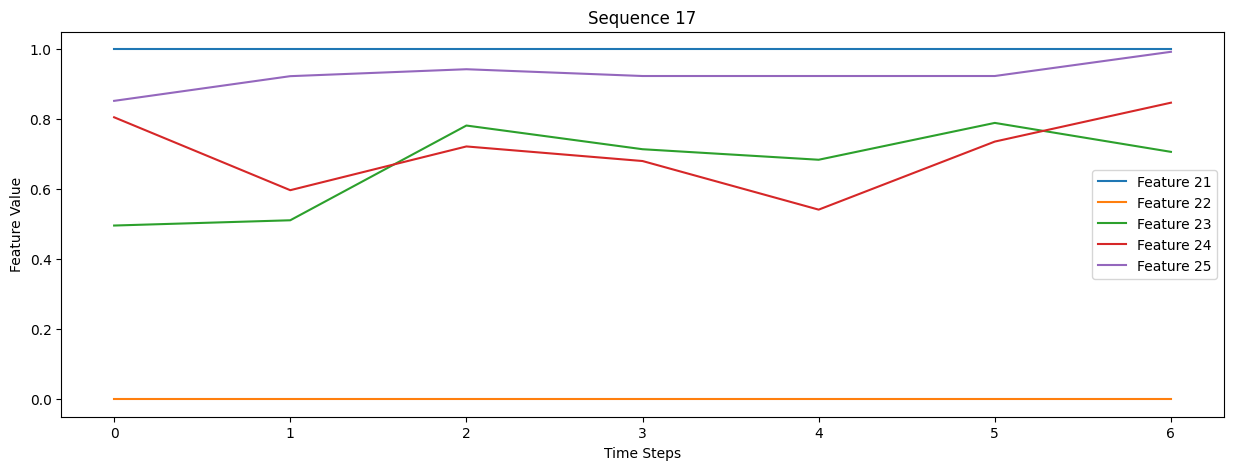

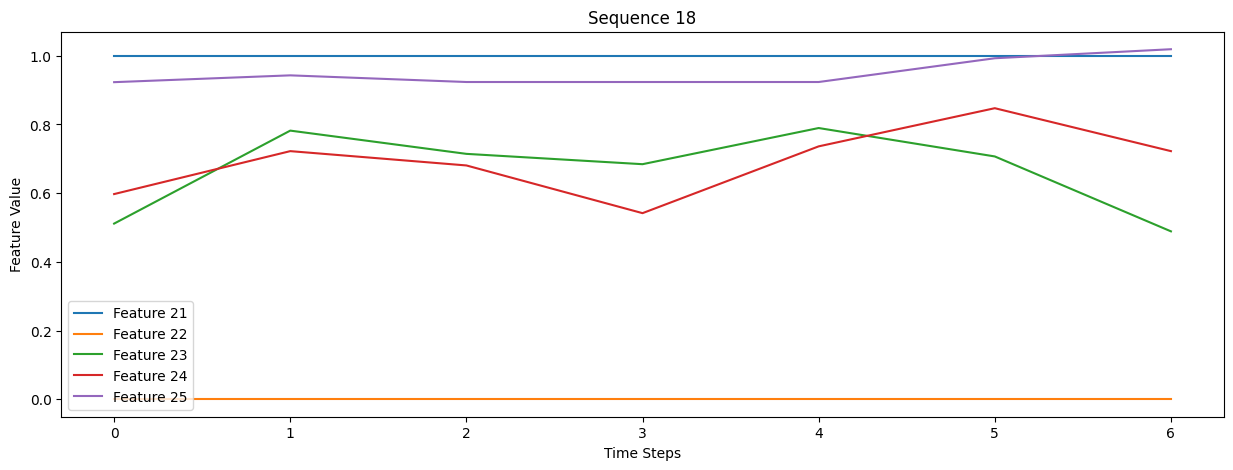

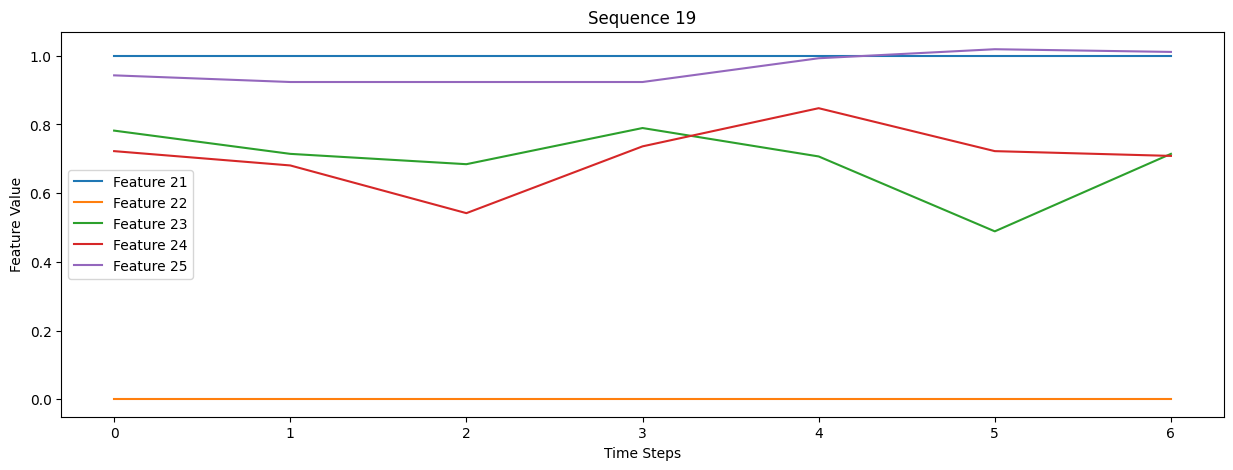

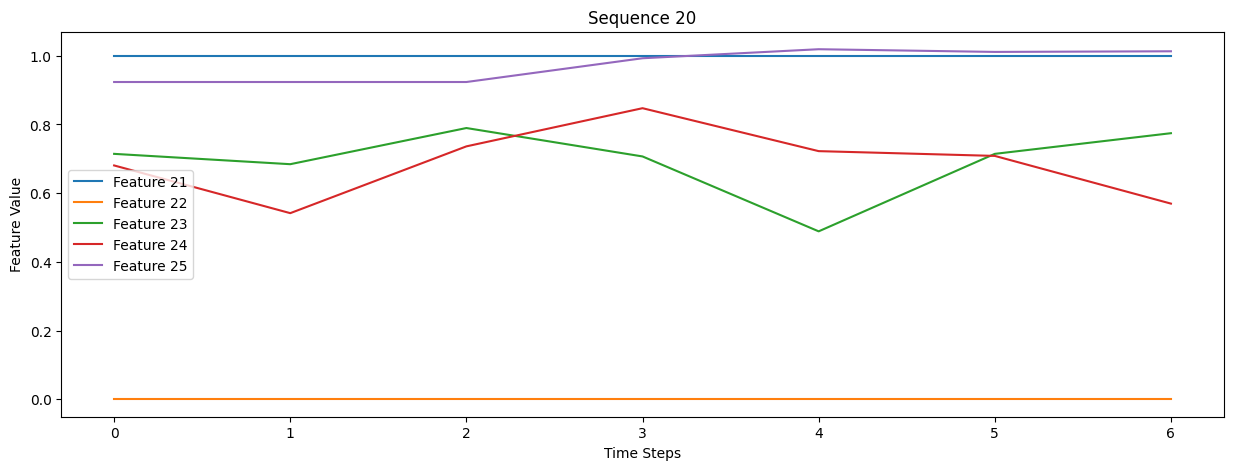

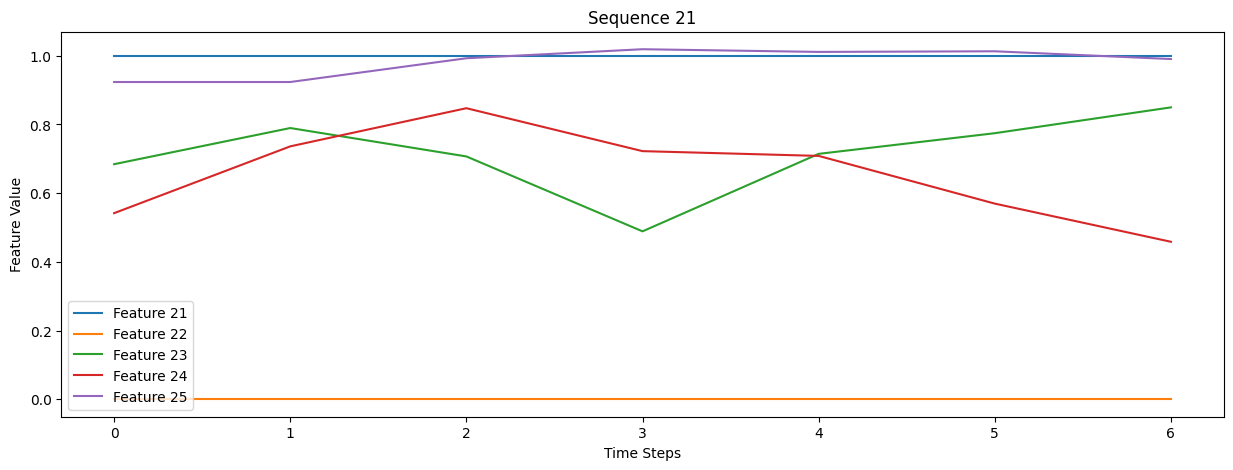

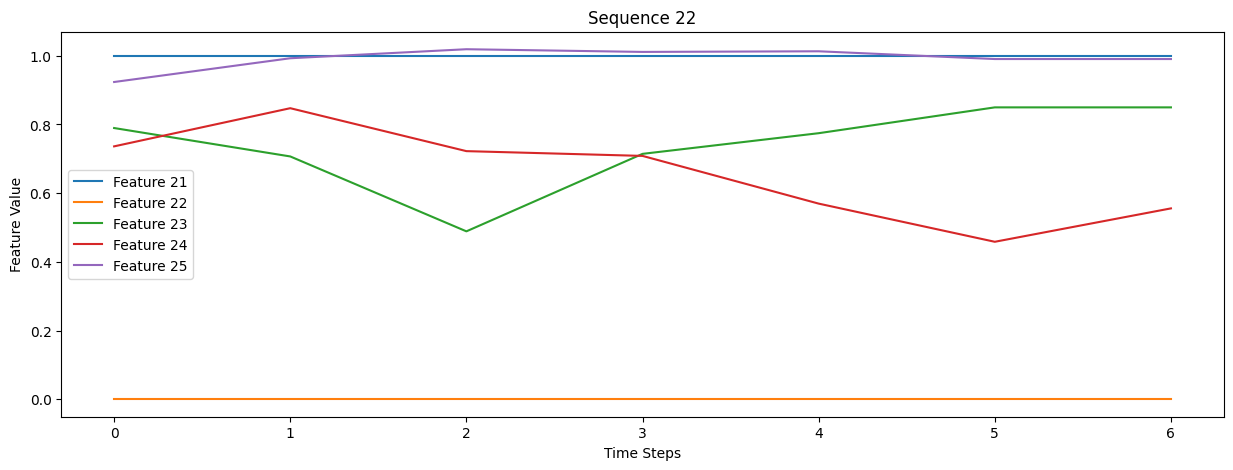

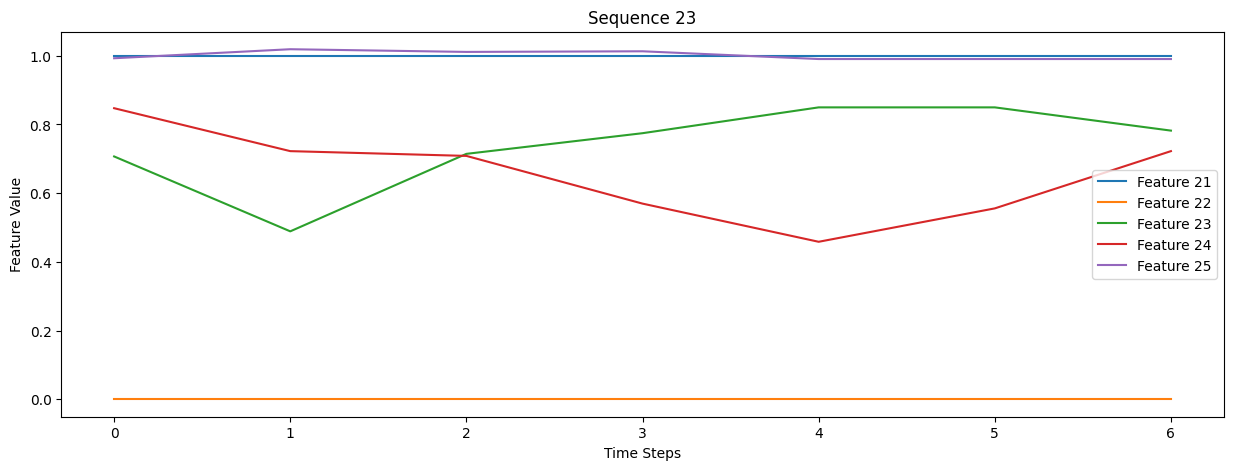

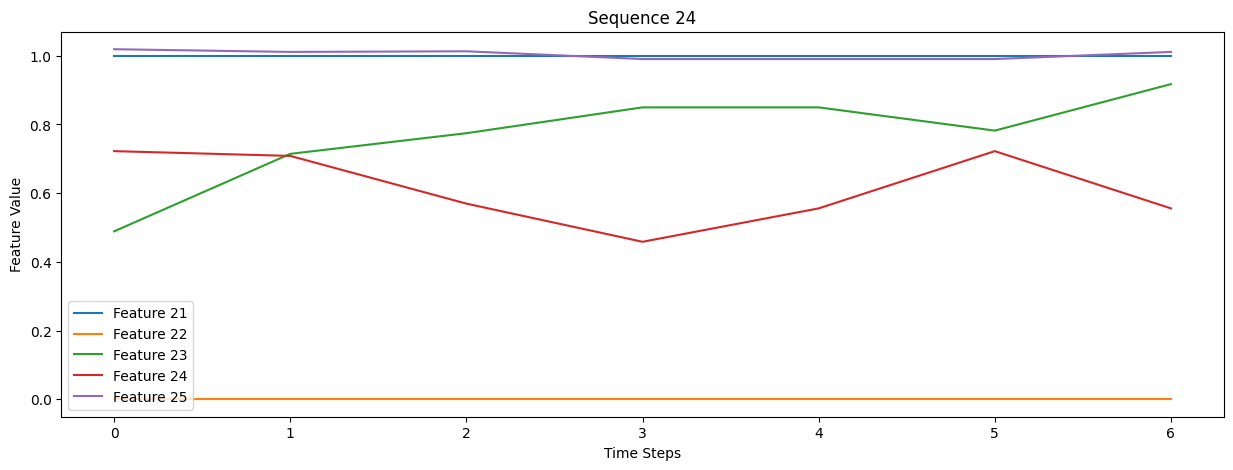

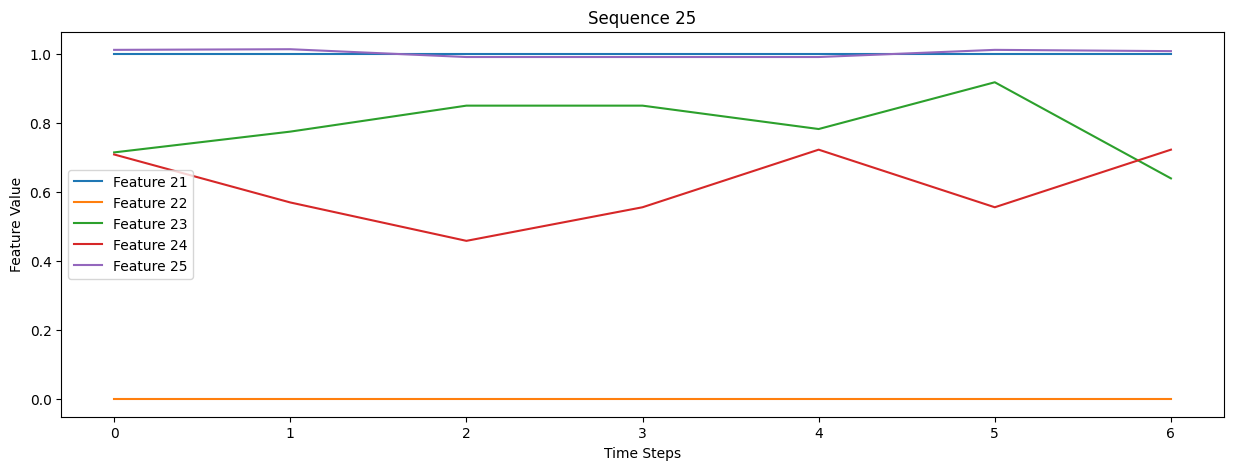

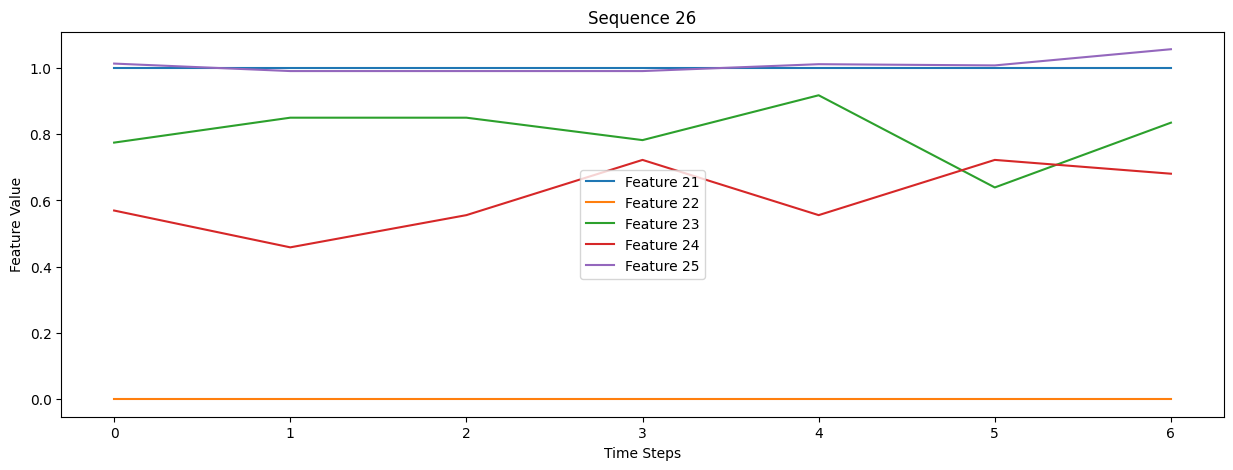

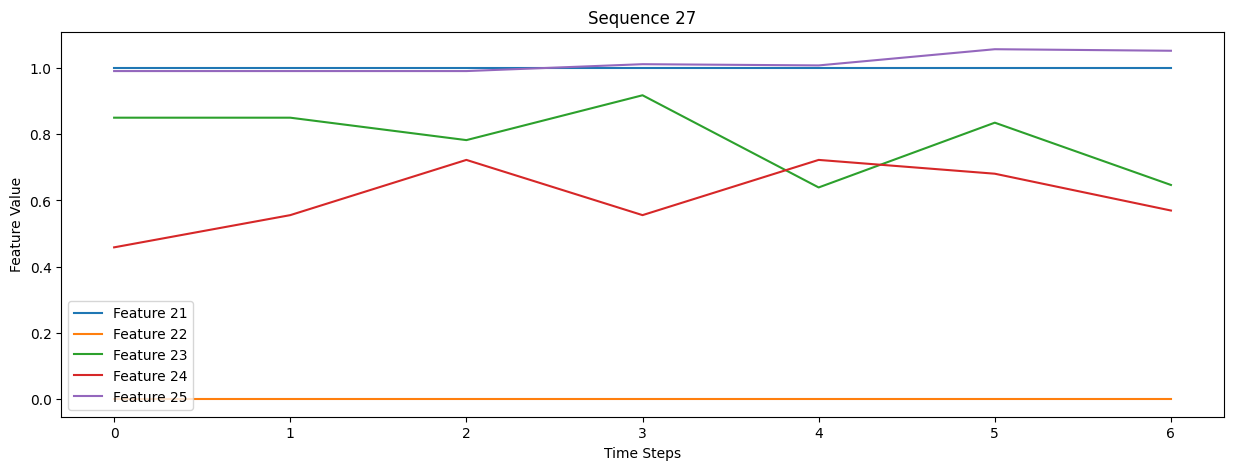

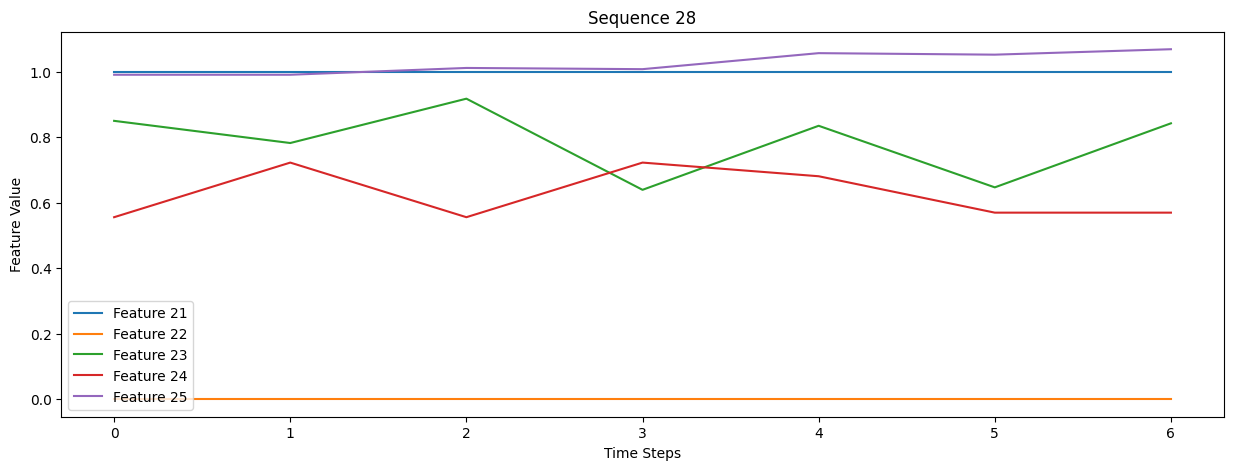

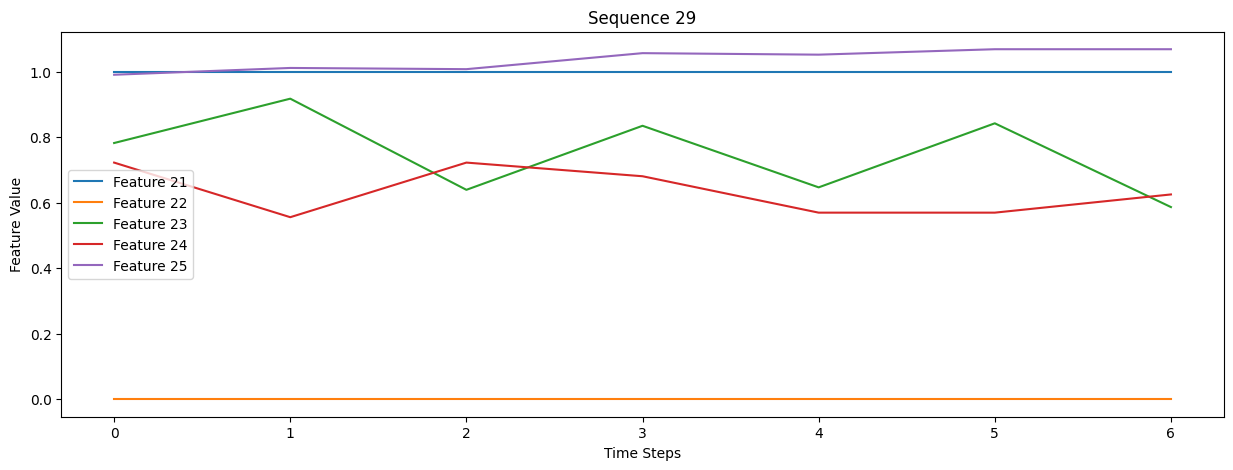

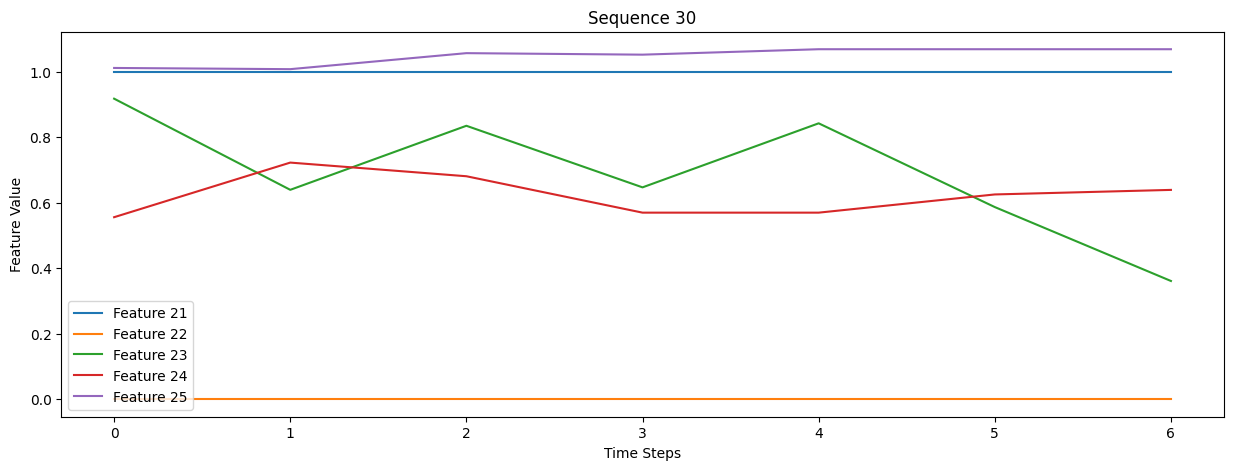

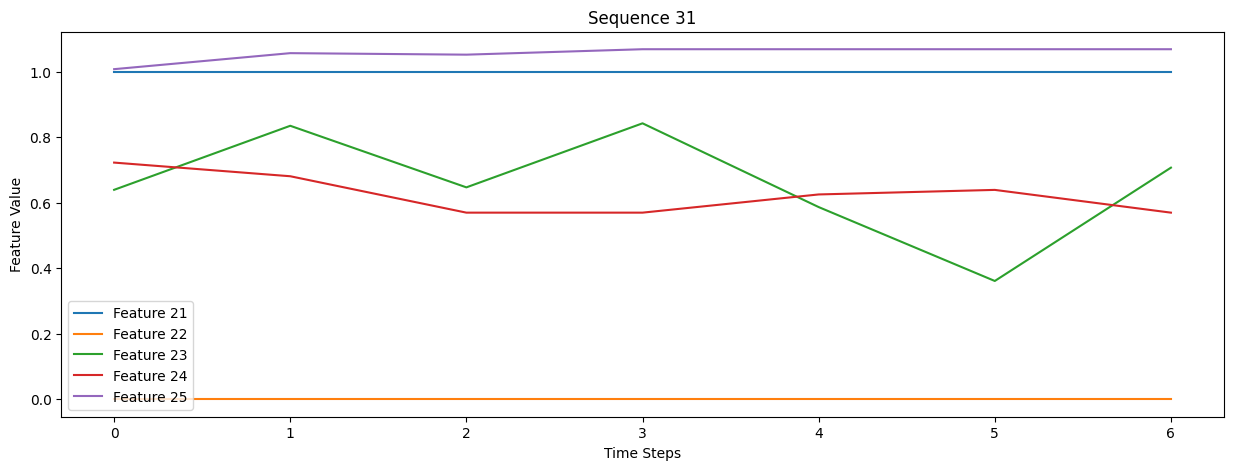

In [ ]:
def visualize_sequences_last_features(X_test, sequence_length, num_features_to_plot=5):
    num_sequences = X_test.shape[0]
    total_features = X_test.shape[2]
    start_feature = max(0, total_features - num_features_to_plot)

    for seq_idx in range(num_sequences):
        plt.figure(figsize=(15, 5))

        for feature_idx in range(start_feature, total_features):
            plt.plot(X_test[seq_idx, :, feature_idx], label=f'Feature {feature_idx + 1}')

        plt.title(f'Sequence {seq_idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.show()

visualize_sequences_last_features(X_test_LSTM_A, sequence_length_test_LSTM_A)

## Hyperparameter tuning:

We will use a Random Search approach to find the best hyperparameters. This method is similar to Grid Search, but instead of testing all possible combinations, it randomly selects and evaluates a subset of them.

*   Units: Represents the number of neurons (units) in the LSTM layer. The range specified includes 50, 100, 150, and 200.

*   Activation: Refers to the activation function used in the LSTM layer. The functions being tested are ReLU, Tanh, and Sigmoid.

During the search, different combinations of these hyperparameters will be tested and evaluated on a validation set. The combination that results in the lowest Root Mean Squared Error (RMSE) will be selected as the best set of hyperparameters.

We also add a dense layer to the model used to map the outputs from the previous LSTM layer to the right ouptut size, acting as a final layer

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
https://keras.io/api/layers/recurrent_layers/lstm/


In [ ]:
# Model LSTM A

def build_model_LSTM_A(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                   input_shape=(X_train_LSTM_A.shape[1], X_train_LSTM_A.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

tuner_LSTM_A = RandomSearch(
    build_model_LSTM_A,
    objective=Objective('val_rmse', direction='min'),
    max_trials=10,
    directory='randomsearch_results_LSTM_A_'
)

tuner_LSTM_A.search(X_train_LSTM_A, y_train_LSTM_A, epochs=100, validation_split=0.2)

best_hps_LSTM_A = tuner_LSTM_A.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best hyperparameters: Units - {best_hps_LSTM_A.get('units')}, Activation - {best_hps_LSTM_A.get('activation')}")


Trial 10 Complete [00h 00m 09s]
val_rmse: 0.1087024137377739

Best val_rmse So Far: 0.10512896627187729
Total elapsed time: 00h 03m 21s
Best hyperparameters: Units - 150, Activation - tanh


In [ ]:
# Model LSTM B

def build_model_LSTM_B(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                   input_shape=(X_train_LSTM_B.shape[1], X_train_LSTM_B.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

tuner_LSTM_B = RandomSearch(
    build_model_LSTM_B,
    objective=Objective('val_rmse', direction='min'),
    max_trials=10,
    directory='randomsearch_results_LSTM_B',
    overwrite=True
)

tuner_LSTM_B.search(X_train_LSTM_B, y_train_LSTM_B, epochs=100, validation_split=0.2)

best_hps_LSTM_B = tuner_LSTM_B.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best hyperparameters: Units - {best_hps_LSTM_A.get('units')}, Activation - {best_hps_LSTM_A.get('activation')}")

Trial 10 Complete [00h 00m 08s]
val_rmse: 0.11372862756252289

Best val_rmse So Far: 0.1029752567410469
Total elapsed time: 00h 01m 25s
Best hyperparameters: Units - 150, Activation - tanh


## Model evaluation

**Model Training and Forecasting Strategy:**

For the LSTM model, the approach is slighltly different because the methode used for the other models is too heavy with LSTM because the model needs to be trained multiple time through the evaluation period.

Instead, the a LSTM model is created and trained on 6 month of past data to being able to understand the trends, then the model is evaluated in real case scenario by generating daily forecasts for the next day, utilizing a rolling window approach with the last 7 days of data to predict each day of the evaluation period.

Bootstrap Aggregation: To improve the model's precision, the training dataset is bootstrapped 20 times. Multiple samples are drawn (with replacement) from the six-month data pool, and the model is trained on these samples. The daily forecast is then derived as the average of these bootstrapped predictions.

**Evaluation Period and Methodology:**

Testing Timeline: The model's effectiveness is evaluated over a 31-day span, from May 1, 2016, to May 31, 2016.

Comparison of Predicted and Actual Sales: Daily forecasted sales are matched against actual sales figures for each corresponding day. The forecasts represent the mean outcome from the bootstrapped models.

Performance Metric: The accuracy of the model is measured using:

*   RMSE
*   RMSE%
*   variance RMSE
*   MAE
*   MAPE
*   MAE%
*   Bias
*   Bias%

This methodology ensures that the model is resilient, adjusts to current market conditions, and reflects a realistic operational forecasting process.

In [ ]:
# Model LSTM A

def forecast_sales_LSTM_A(X_train, y_train, X_test, best_hps, n_bootstrap):
    individual_day_predictions = np.zeros((n_bootstrap, X_test.shape[0]))

    for i in range(n_bootstrap):
        indices = np.random.choice(np.arange(X_train.shape[0]), size=X_train.shape[0], replace=True)
        X_train_bootstrap = X_train[indices]
        y_train_bootstrap = y_train[indices]

        model = tuner_LSTM_A.hypermodel.build(best_hps)
        model.fit(X_train_bootstrap, y_train_bootstrap, epochs=100, validation_split=0.2, verbose=0)
        individual_predictions = model.predict(X_test).ravel()
        individual_day_predictions[i] = individual_predictions

    predictions = np.mean(individual_day_predictions, axis=0)
    return predictions

In [ ]:
# Model LSTM B

def forecast_sales_LSTM_B(X_train, y_train, X_test, best_hps, n_bootstrap):
    individual_day_predictions = np.zeros((n_bootstrap, X_test.shape[0]))

    for i in range(n_bootstrap):
        indices = np.random.choice(np.arange(X_train.shape[0]), size=X_train.shape[0], replace=True)
        X_train_bootstrap = X_train[indices]
        y_train_bootstrap = y_train[indices]

        model = tuner_LSTM_B.hypermodel.build(best_hps)
        model.fit(X_train_bootstrap, y_train_bootstrap, epochs=100, validation_split=0.2, verbose=0)
        individual_predictions = model.predict(X_test).ravel()
        individual_day_predictions[i] = individual_predictions

    predictions = np.mean(individual_day_predictions, axis=0)
    return predictions

Evaluation of the forecast using RMSE, MAE, MAPE, and MAE%.

In [ ]:
def evaluate_forecast(predictions, actual_data):
    errors = []
    mae_values = []
    mape_values = []

    for date, pred in predictions.items():
        if date in actual_data.index:
            actual_sales = actual_data.at[date, 'unit_sales']
            error = pred - actual_sales
            errors.append(error)
            mae_values.append(abs(error))
            if actual_sales != 0:
                mape_values.append((abs(error) / actual_sales) * 100)

    # Calculate overall metrics
    actuals = [actual_data.at[date, 'unit_sales'] for date in predictions if date in actual_data.index]
    preds = [predictions[date] for date in predictions if date in actual_data.index]
    overall_rmse = sqrt(mean_squared_error(actuals, preds))
    overall_mae = np.mean(mae_values)  # Mean Absolute Error
    overall_mape = np.mean(mape_values) if mape_values else None  # Mean Absolute Percentage Error
    mae_percent = (np.sum(mae_values) / np.sum(actuals)) * 100 if actuals else None  # MAE as a percentage of total actuals
    bias = np.mean(errors) if errors else None  # Calculate bias
    bias_percent = (np.sum(errors) / np.sum(actuals)) * 100 if actuals else None  # Bias as a percentage of total actuals
    overall_rmse_percent = (overall_rmse / np.mean(actuals)) * 100 if actuals else None  # RMSE as a percentage of total actuals

    # Compute the variance of daily RMSEs
    variance_of_rmses = np.var([sqrt(mean_squared_error([actual], [pred])) for actual, pred in zip(actuals, preds)])

    # Format the output as a table
    results = {
        "Metric": ["Overall RMSE", "RMSE %", "Variance of RMSEs", "Overall MAE", "MAE %", "Overall MAPE", "Bias", "Bias %"],
        "Value": [overall_rmse, overall_rmse_percent, variance_of_rmses, overall_mae, mae_percent, overall_mape, bias, bias_percent]
    }

    return pd.DataFrame(results)

Plot the forecasted sales against the actual sales.

In [ ]:
def plot_forecast_vs_actual(predictions, actual_data, model_name):

    # Convert predictions dictionary to DataFrame for easier plotting
    pred_df = pd.DataFrame(list(predictions.items()), columns=['date', 'predicted_sales'])
    pred_df['date'] = pd.to_datetime(pred_df['date'])
    pred_df.set_index('date', inplace=True)

    # Plot settings
    plt.figure(figsize=(12, 6))
    plt.plot(pred_df.index, pred_df['predicted_sales'], label='Predicted Sales', marker='o', linestyle='-', color='blue')
    plt.plot(actual_data.index, actual_data['unit_sales'], label='Actual Sales', marker='x', linestyle='--', color='red')

    # Enhance the plot
    plt.title(f'{model_name} - Forecasted Sales vs Actual Sales')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate date labels for better readability

    # Show the plot
    plt.tight_layout()
    plt.show()

## Result LSTM A

Forecast the value for the evaluation period

In [ ]:
# Model LSTM A

# Number of bootstrap sample
n_bootstrap_LSTM_A = 20

# Predict the sales
predictions_LSTM_A = forecast_sales_LSTM_A(X_train_LSTM_A, y_train_LSTM_A, X_test_LSTM_A, best_hps_LSTM_A, n_bootstrap_LSTM_A)

# Scale the predictions back to the original scale
temp_array_LSTM_A = np.zeros((len(predictions_LSTM_A), train_scaled_LSTM_A.shape[1]))
temp_array_LSTM_A[:, 0] = predictions_LSTM_A.ravel()
test_predictions_original_scale_LSTM_A = scaler_LSTM_A.inverse_transform(temp_array_LSTM_A)[:, 0]

dates_LSTM_A = test_A_LSTM_A.index[:len(test_predictions_original_scale_LSTM_A)]
predictions_LSTM_A = dict(zip(dates_LSTM_A, test_predictions_original_scale_LSTM_A))


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 285ms/step


Evaluate the results

In [ ]:
# Model LSTM A

# Extract actual sales data for the test period
actual_sales_LSTM_A = pd.DataFrame({
    'unit_sales': test_A_LSTM_A['unit_sales'].values
}, index=test_A_LSTM_A.index)

# Print Model Evaluation
evaluation_results = evaluate_forecast(predictions_LSTM_A, actual_sales_LSTM_A)
print(evaluation_results)

              Metric      Value
0       Overall RMSE  14.578441
1             RMSE %  23.489172
2  Variance of RMSEs  94.837961
3        Overall MAE  10.848639
4              MAE %  17.479616
5       Overall MAPE  16.421232
6               Bias  -4.490294
7             Bias %  -7.234881


Predicted value for each day

In [ ]:
# Model LSTM A

print("Sample predictions:")
for date in list(predictions_LSTM_A.keys())[:]:
    print(f"{date}: {predictions_LSTM_A[date]}")

Sample predictions:
2016-05-01 00:00:00: 96.27437164783478
2016-05-02 00:00:00: 67.33484948724508
2016-05-03 00:00:00: 58.874644726514816
2016-05-04 00:00:00: 59.20111601352691
2016-05-05 00:00:00: 55.908598616719246
2016-05-06 00:00:00: 59.2140139400959
2016-05-07 00:00:00: 68.96806936264038
2016-05-08 00:00:00: 81.45341609716415
2016-05-09 00:00:00: 62.55229749977588
2016-05-10 00:00:00: 46.280592614412306
2016-05-11 00:00:00: 47.08636410236358
2016-05-12 00:00:00: 45.15363337360322
2016-05-13 00:00:00: 40.793693334609266
2016-05-14 00:00:00: 61.31313641667365
2016-05-15 00:00:00: 91.44933117628098
2016-05-16 00:00:00: 58.48079586029053
2016-05-17 00:00:00: 48.51514681577682
2016-05-18 00:00:00: 40.41725512780249
2016-05-19 00:00:00: 36.820345076918606
2016-05-20 00:00:00: 42.87800831766799
2016-05-21 00:00:00: 59.88180368542672
2016-05-22 00:00:00: 75.5059651017189
2016-05-23 00:00:00: 56.769809636473646
2016-05-24 00:00:00: 40.80674700215459
2016-05-25 00:00:00: 43.45564121119677
2

Visualization of the results

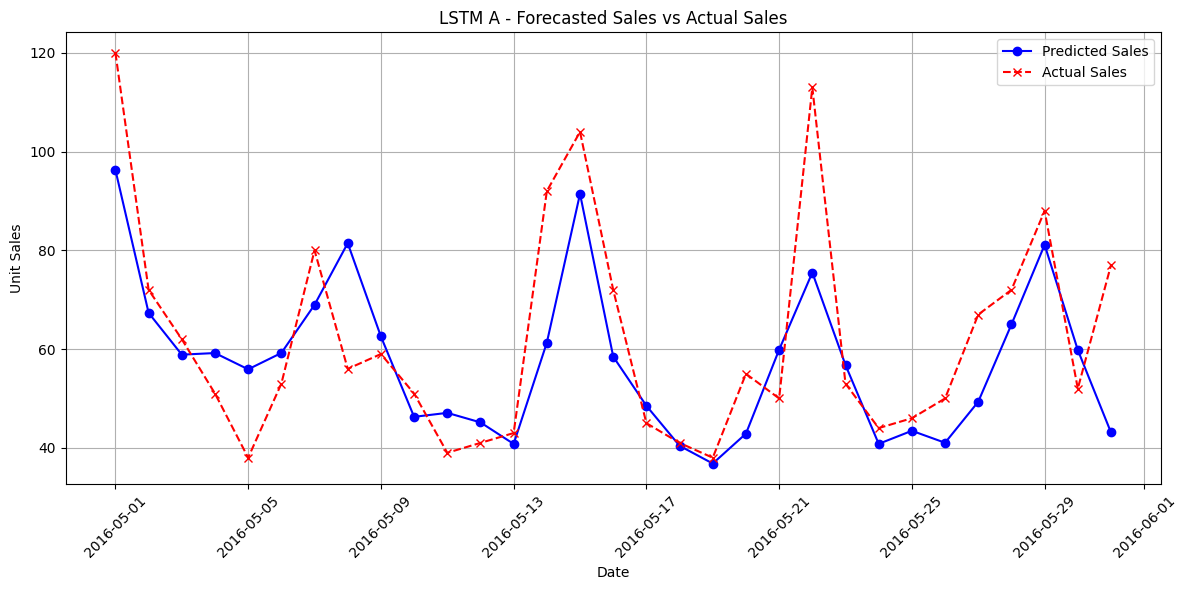

In [ ]:
# Model LSTM A
model_name= 'LSTM A'
plot_forecast_vs_actual(predictions_LSTM_A, actual_sales_LSTM_A, model_name)

## Result LSTM B

Forecast the value for the evaluation period

In [ ]:
# Model LSTM B

# Number of bootstrap samples
n_bootstrap_LSTM_B = 20

# Predict the sales
predictions_LSTM_B = forecast_sales_LSTM_B(X_train_LSTM_B, y_train_LSTM_B, X_test_LSTM_B, best_hps_LSTM_B, n_bootstrap_LSTM_B)

# Scale the predictions back to the original scale
temp_array_LSTM_B = np.zeros((len(predictions_LSTM_B), train_scaled_LSTM_B.shape[1]))
temp_array_LSTM_B[:, 0] = predictions_LSTM_B.ravel()
test_predictions_original_scale_LSTM_B = scaler_LSTM_B.inverse_transform(temp_array_LSTM_B)[:, 0]

dates_LSTM_B = test_B_LSTM_B.index[:len(test_predictions_original_scale_LSTM_B)]
predictions_LSTM_B = dict(zip(dates_LSTM_B, test_predictions_original_scale_LSTM_B))

1/1 [==============================] - 0s 278ms/step


Evaluate the results

In [ ]:
# Model LSTM B

# Extract actual sales data for the test period
actual_sales_LSTM_B = pd.DataFrame({
    'unit_sales': test_B_LSTM_B['unit_sales'].values
}, index=test_B_LSTM_B.index)

# Print Model Evaluation
evaluation_results = evaluate_forecast(predictions_LSTM_B, actual_sales_LSTM_B)
print(evaluation_results)

              Metric       Value
0       Overall RMSE   23.079556
1             RMSE %   30.406555
2  Variance of RMSEs  206.889578
3        Overall MAE   18.049275
4              MAE %   23.779325
5       Overall MAPE   23.160660
6               Bias  -12.742255
7             Bias %  -16.787501


Predicted value for each day

In [ ]:
# Model LSTM B

print("Sample predictions:")
for date in list(predictions_LSTM_B.keys())[:]:
    print(f"{date}: {predictions_LSTM_B[date]}")

Sample predictions:
2016-05-01 00:00:00: 83.52106709256768
2016-05-02 00:00:00: 59.73882523700594
2016-05-03 00:00:00: 52.133503008261314
2016-05-04 00:00:00: 51.2330814126879
2016-05-05 00:00:00: 52.49156967122108
2016-05-06 00:00:00: 62.867546399310235
2016-05-07 00:00:00: 81.02780397683384
2016-05-08 00:00:00: 77.88160999566318
2016-05-09 00:00:00: 64.20371477082371
2016-05-10 00:00:00: 67.16698283851146
2016-05-11 00:00:00: 65.76115307584405
2016-05-12 00:00:00: 63.069533247500665
2016-05-13 00:00:00: 60.856141874939205
2016-05-14 00:00:00: 72.27661234438419
2016-05-15 00:00:00: 76.99397968649863
2016-05-16 00:00:00: 82.20734469741582
2016-05-17 00:00:00: 82.26976727843284
2016-05-18 00:00:00: 74.79992334395646
2016-05-19 00:00:00: 64.6900384798646
2016-05-20 00:00:00: 61.12358414009214
2016-05-21 00:00:00: 68.5555098593235
2016-05-22 00:00:00: 73.78861463069916
2016-05-23 00:00:00: 66.3587188795209
2016-05-24 00:00:00: 67.34040905833244
2016-05-25 00:00:00: 53.76854302585125
2016-

Visualization of the results

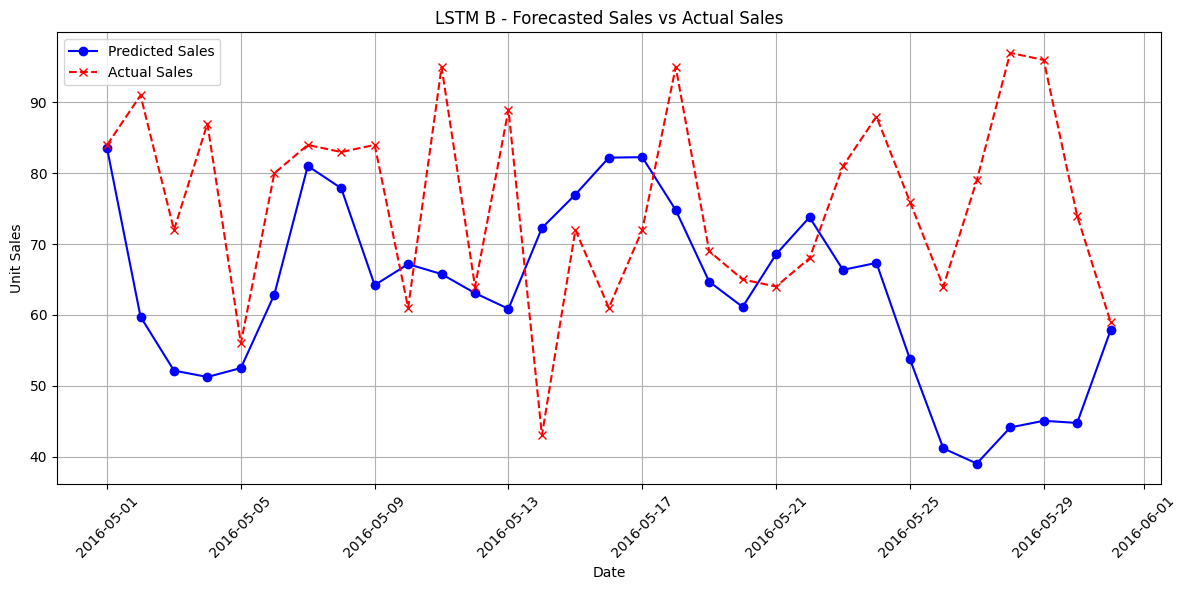

In [ ]:
# Model LSTM B

model_name = 'LSTM B'
plot_forecast_vs_actual(predictions_LSTM_B, actual_sales_LSTM_B, model_name)